# Day 4 課題

### 目次
### - 1. Day 1, 2, 3 の作業内容
### - 2. k-近傍法による予測
### - 3. PCAによる次元削減
### - 4. ハイパーパラメータ最適化

## 1. Day 1, 2 の作業内容
 
### 各変数について
- ID：不要と判断し削除
- name：用いる変数の中ではnameにのみ欠損値があった。欠損値が少ないため、削除して対応した。
- name_length：nameの単語数と成功確率に相関があるのではないかと考え、nameの単語数の変数を追加した。
- category：カテゴリーの種類によって成功確率に違いが見られた。ダミー変数を追加し予測に用いた。データ数の少ないカテゴリーもあり、予測に用いた場合、過学習の懸念がある。
- main_category：成功確率との関係が見られた。ダミー変数を追加し、予測に用いた。
- currency：成功確率との関係が見られた。ダミー変数を追加し、予測に用いた。
- country：成功確率との関係が見られた。ダミー変数を追加し、予測に用いたが、データ数の少ないカテゴリーもあり、予測に用いた場合、過学習の懸念がある。
- goal, usd_goal_real：分布について確認すると、goalの最大値100000000.0をとっているデータが多く見られた。これらは正常な値である可能性もあるが、設定された上限の値を超えていて、便宜的に100000000.0となっている可能性がある。そのためgoalがこれらの値となっているデータについては除外することとする。goalよりも通貨が揃っているusd_goal_realの方が適切と判断し、こちらを予測に用いている。
- deadline, launched：開始から、終了までの日数を求め、変数deltaとして追加した。deltaの外れ値について確認し、最大値91日のものがいくつか見られたが、クラウドファンディングの設定可能日数が91日であり、そのまま使用して問題ないと判断した。日数が0のデータも存在したが、実際に開始日と終了日を確認したところ、期間が一日未満であったため、こちらも問題ないと判断した。
- pledged, usd_peldged, usd_pledged_real, backers：クラウドファンディングの結果得られる値のため、今回は使用不可として削除
- state：目的変数、今回は結果の確定しているsuccessful, failedのみを用い、その他の値となっているデータは扱わないこととした。successful=1, failed=0 として数値に置き換えた。 

量的変数に関しては、標準化して計算に用いた。各変数名に_stdを付けたものを新たにdata frameに追加している。

### 各変数の相関
heatmup, 散布図行列を用いて、各変数の相関を調べた。
- name_lengthとstateには正の相関がみられ、名前の情報量が多い方が、成功しやすい傾向が示唆された。
- usd_goal_realとstateの相関係数は小さかった。目標金額と成功確率は関係しているように思われるが、相関係数には現れていない可能性もある。
- usd_goal_realとdeltaには小さな負の相関が見られた。直感に反するが、関係が相関係数で表現できていない可能性もある。

### ロジスティック回帰による予測
以下の二通の説明変数を用いて、stateの値を予測し、訓練誤差の評価、および交差検証による汎化誤差の評価を行った。
1. name_length_std, usd_goal_std, currencyおよび main_categoryのダミー変数, delta_std 
2. 上記にcountry, categoriのダミー変数を追加したもの
1の説明変数を用いたモデルでは、訓練データ、テストデータに対する正答率が共に64.9%であり、
2の説明変数を用いたモデルでは、それぞれ、67.2%, 67.1%であった。

### ロジスティック回帰の正則化項の検討
- より高い精度が見られた2の説明変数を用いて、ロジスティック回帰の正則化項を検討した。
- L1, L2どちらの場合でも正則化項を加えることで汎化誤差が小さくなった。
- 正則化項の係数となるパラメータalphaのチューニングを行い、誤差が小さくなるalphaの値を発見した。
- L1正則化において、学習後のモデルの各説明変数の重みを確認することで、特に重要な変数の確認を行った。

### サポートベクタ―マシンによる予測モデル構築
- カーネル関数はrbfを利用し、SVMによる予測モデルを構築した。
- グリッドサーチによるハイパーパラメータのチューニングを行い、C, gammaの良い値を見つけたが、計算時間の問題で十分ではない可能性がある。

### 特徴量選択
3通りの方法で特徴量の選択を行った。
- フィルター法：currencyとcountryの一部の値の間、およびcategoryとmain_categoryの一部の間に相関がみられた。
- ラッパー法；テゴリー、通貨のダミー変数うち、いくつかが不要という結果が得られた。
- LASSO：カテゴリー、メインカテゴリー、国、通貨の一部が不要である一方、重要な説明変数もカテゴリーの一部であった。


### 木モデルによる予測
決定木、ランダムフォレスト、アダブーストによる予測モデルの構築を行った。ランダムフォレスト、アダブーストについてはパラメータのチューニングを行った。それぞれの精度は以下の通りである。
- ランダムフォレスト：68%
- アダブースト：69%

また、両モデルともusd_goal_real, categoryが特に重要で、coutry, currencyは重要度が低いという結果が得られた。


### ニューラルネットワークによる予測モデル構築
ニューラルネットワークモデルを構築し、学習、予測を行った。制度は67％であったが、パラメータのチューニング等はまだ行っていない。

これまでの検討では、アダブーストが最も精度の良いモデルとなっており、その汎化性能は正答率69%である。また一度の学習にかかる時間も比較的短
く、扱いやすかった。

#### これまでの処理を行ったData Frameを以下に示す。

In [59]:
# 使用するライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [6]:
df_day4_1=pd.read_csv('Day1_3.csv').drop(['usd_goal_real_std', 'name_length_std', 'delta_std', 'deadline', 'name', 'launched','goal'], axis=1)
df_day4_1.head()

,state,usd_goal_real,name_length,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1,50000.00,3,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1000.00,8,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,12500.00,4,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,6469.73,9,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,250.00,6,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 2. k-近傍法による予測

#k-近傍法によってクラウドファンディングの成功・失敗を予測する。

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
#データの準備
X = df_day4_1.drop(["state"], axis=1)
y = df_day4_1["state"]
X.head()

,usd_goal_real,name_length,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,50000.00,3,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1000.00,8,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12500.00,4,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6469.73,9,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,250.00,6,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
#データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)

In [11]:
#量的変数の標準化
stdc =  StandardScaler()
stdc.fit(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])
X_train.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])                                                                    
X_test.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_test.loc[:, ["usd_goal_real", "name_length", "delta"]])
X_train.head()

C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,usd_goal_real,name_length,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
155831,-0.041426,-1.317835,-0.939474,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
187150,-0.026568,-0.954873,-0.309452,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14843,-0.034951,-0.228947,0.005558,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
173910,-0.048622,0.134016,-0.624463,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258813,-0.042146,-0.228947,0.478074,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# k-近傍法モデルの構築。今回は5つの近傍点の多数決で判定する。
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
# ラベルを予測する。
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6417608925071612


In [17]:
#　混同行列を表示
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test.values, y_pred,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)

              precision    recall  f1-score   support

      failed       0.69      0.73      0.71     39695
  successful       0.56      0.51      0.54     26635

    accuracy                           0.64     66330
   macro avg       0.62      0.62      0.62     66330
weighted avg       0.64      0.64      0.64     66330



,予測 = failed,予測 = successful
正解 = failed,28888,10807
正解 = successful,12955,13680


k-近傍法による予測を行った。データ数が多いため、予測にかかる時間が長かった。精度も64%とあまり高くはなかった。

## 3. PCAによる次元削減

In [18]:
from sklearn.decomposition import PCA

データの準備、量的変数を標準化する。

In [46]:
X = df_day4_1.drop(["state"], axis=1)
y = df_day4_1["state"]
X.head()

,usd_goal_real,name_length,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,50000.00,3,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1000.00,8,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12500.00,4,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6469.73,9,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,250.00,6,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
#変数の標準化
stdc =  StandardScaler()
stdc.fit(X)
X = stdc.transform(X)                                                                    

In [49]:
pca = PCA(n_components=2) #主成分分析用のオブジェクトをつくる。
pca.fit(X) #主成分分析の実行

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [50]:
#各主成分の寄与率を表示
print("寄与率=",pca.explained_variance_ratio_)
print("合計＝", pca.explained_variance_ratio_.sum())

寄与率= [0.0177669  0.01075298]
合計＝ 0.02851988503209115


In [51]:
# 新しい軸に射影
X_pca = pca.fit_transform(X)
X_pca

array([[-0.99264282,  0.01432336],
       [-1.12396969,  0.03865224],
       [-1.56534785,  0.48232329],
       ...,
       [-1.43078051, -1.06284992],
       [-0.30388867,  2.0208796 ],
       [-1.05713374, -0.46773573]])

In [52]:
#新しいベクトルへの射影をData frame化
pca_df = pd.DataFrame(X_pca, columns=["PC1","PC2"])
pca_df.head()

,PC1,PC2
0,-0.992643,0.014323
1,-1.123970,0.038652
2,-1.565348,0.482323
3,4.031619,-1.960843
4,-1.438973,0.421656


In [53]:
pca_df["state"]=y
pca_df

,PC1,PC2,state
0,-0.992643,0.014323,1
1,-1.123970,0.038652,1
2,-1.565348,0.482323,1
3,4.031619,-1.960843,1
4,-1.438973,0.421656,1
...,...,...,...
331641,-1.121965,0.014888,0
331642,-1.316004,-1.279981,0
331643,-1.430781,-1.062850,0
331644,-0.303889,2.020880,0


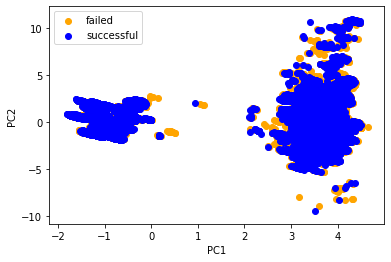

In [54]:
#主成分分析を行ったデータの可視化　成功・失敗で色分けして表示する。
fig = plt.figure()
ax = fig.add_subplot(111)
x1 =  pca_df[pca_df['state']==1]['PC1']
y1 =  pca_df[pca_df['state']==1]['PC2']
x2 =  pca_df[pca_df['state']==0]['PC1']
y2 =  pca_df[pca_df['state']==0]['PC2']
ax.scatter(x2, y2, c="orange", label='failed')
ax.scatter(x1, y1, c="blue", label='successful')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

主成分分析を行い、データを二次元に圧縮し、可視化した。しかし、第二主成分まででは寄与率が小さいため、データを表現しきれず、成功と失敗の違いはわからなかった。

## 4. ハイパーパラメータ最適化



これまで構築したモデルのなかで、Adaboostが最も良い精度であった。ブースティングに着目し、勾配ブースティングの手法である、XGboost, LightGBMを用いてハイパーパラメータの最適化を行い、さらなる精度向上を目指す。

### 4-1 データの準備
カテゴリ変数はLabel Encoderで変数化する。

In [60]:
#データの読み込み Day1でダミー変数の追加以外の処理を行った後のデータを読み込む。
# Day1では 全てのデータの値を用いて、標準化を行っていたので、一旦標準化を行った_stdの列を削除し、訓練データの値を基にやりなおす。(Day2指摘事項対応)
df_day3 = pd.read_csv('Day1.csv').drop(['usd_goal_real_std', 'name_length_std', 'delta_std'], axis=1)
df_day3.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,name_length,delta
0,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 00:00:00,50000.0,2016-02-26 13:38:27,1,US,50000.00,3,34
1,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 00:00:00,1000.0,2014-12-01 18:30:44,1,US,1000.00,8,19
2,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08 00:00:00,12500.0,2013-03-09 06:42:58,1,US,12500.00,4,29
3,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03 00:00:00,5000.0,2017-04-05 19:44:18,1,GB,6469.73,9,27
4,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17 00:00:00,250.0,2012-08-02 14:11:32,1,US,250.00,6,14


In [61]:
#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#categoryに出てくるカテゴリを数値に変換
le = le.fit(df_day3['category'])
df_day3['category'] = le.transform(df_day3['category'])

#main_categoryに出てくるカテゴリを数値に変換
le = le.fit(df_day3['main_category'])
df_day3['main_category'] = le.transform(df_day3['main_category'])

#currencyに出てくるカテゴリを数値に変換
le = le.fit(df_day3['currency'])
df_day3['currency'] = le.transform(df_day3['currency'])

#categoryに出てくるカテゴリを数値に変換
le = le.fit(df_day3['country'])
df_day3['country'] = le.transform(df_day3['country'])

df_day3.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,name_length,delta
0,Monarch Espresso Bar,123,7,13,2016-04-01 00:00:00,50000.0,2016-02-26 13:38:27,1,22,50000.00,3,34
1,Support Solar Roasted Coffee & Green Energy! ...,58,7,13,2014-12-21 00:00:00,1000.0,2014-12-01 18:30:44,1,22,1000.00,8,19
2,Lisa Lim New CD!,72,10,13,2013-04-08 00:00:00,12500.0,2013-03-09 06:42:58,1,22,12500.00,4,29
3,Tombstone: Old West tabletop game and miniatur...,136,8,5,2017-05-03 00:00:00,5000.0,2017-04-05 19:44:18,1,9,6469.73,9,27
4,Mike Corey's Darkness & Light Album,90,10,13,2012-08-17 00:00:00,250.0,2012-08-02 14:11:32,1,22,250.00,6,14


In [62]:
X = df_day3.drop(['state', 'name', 'deadline', 'launched', 'goal'], axis=1)
y = df_day3['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)
X.head()

,category,main_category,currency,country,usd_goal_real,name_length,delta
0,123,7,13,22,50000.00,3,34
1,58,7,13,22,1000.00,8,19
2,72,10,13,22,12500.00,4,29
3,136,8,5,9,6469.73,9,27
4,90,10,13,22,250.00,6,14


In [63]:
#量的変数の標準化
stdc =  StandardScaler()
stdc.fit(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])
X_train.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])                                                                    
X_test.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_test.loc[:, ["usd_goal_real", "name_length", "delta"]])

C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### 4-2 XGboost

XGboostを利用した、予測モデルの構築、パラメータの最適化を行う。

In [128]:
#ライブラリのインポート
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

In [66]:
#データをXGboostで利用できる形式に
dtrain = xgb.DMatrix(X_train, label=y_train)

In [123]:
#パラメータの設定、学習
param = {'max_depth': 7, 'eta': 0.1, 'objective': 'binary:logistic'}
num_round = 50
bst = xgb.train(param, dtrain, num_round)

In [119]:
#予測　結果は確立で返される。
dtest = xgb.DMatrix(X_test)
y_est = bst.predict(dtest)
y_est

array([0.18333524, 0.27449042, 0.50154984, ..., 0.51816607, 0.5017461 ,
       0.24378373], dtype=float32)

In [120]:
#予測値をクラスに変換
for i in range(len(y_est)):
    y_est[i] = 0 if y_est[i]<0.5 else 1
y_est

array([0., 0., 1., ..., 1., 1., 0.], dtype=float32)

In [121]:
#　混同行列を表示
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test, y_est,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)

              precision    recall  f1-score   support

      failed       0.71      0.81      0.76     39695
  successful       0.64      0.50      0.56     26635

    accuracy                           0.69     66330
   macro avg       0.67      0.66      0.66     66330
weighted avg       0.68      0.69      0.68     66330



,予測 = failed,予測 = successful
正解 = failed,32188,7507
正解 = successful,13303,13332


XGboostによる予測を行うことができた。ランダムサーチによるパラメータのチューニングを行う。

In [132]:
cv_params = {'objective':['binary:logistic'],
             'n_estimators':[50000],
             'random_state':[1234],
             'learning_rate':[0.01, 0.1, 0.3, 0.5, 1 ],
             'min_child_weight':[1,2,3,4,5,6,7,8,9,10],
             'max_depth':[1,2,3,4,5,6,7,8,9,10],
             'colsample_bytree':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
             'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
            }
 
cls = xgb.XGBClassifier()
cls_rdn = RandomizedSearchCV(cls,
                             cv_params,
                             cv=KFold(2, random_state=1234),
                             random_state=1234,
                             n_iter=30,
                             iid=False,
                             scoring='accuracy')
cls_rdn.fit(X_train,
            y_train,
            early_stopping_rounds=50,
            eval_set=[(X_test, y_test)],
            eval_metric='error',
            verbose=0)

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=1234, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=No...
                                        'learning_rate': [0.01, 0.1, 0.3, 0.5,
                                                          1],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
           

In [134]:
#ベストスコア、パラメータを表示
print(cls_rdn.best_params_)
print(cls_rdn.best_score_)

{'subsample': 1.0, 'random_state': 1234, 'objective': 'binary:logistic', 'n_estimators': 50000, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
0.6888465075607955


In [135]:
#ベストなパラメータを用いて学習、テストデータの予測を行う。
bst_2 = xgb.XGBClassifier()
bst_2 = xgb.train(cls_rdn.best_params_, dtrain, num_round)

[10:08:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [137]:
#予測　結果は確立で返される。
dtest = xgb.DMatrix(X_test)
y_est = bst.predict(dtest)
#予測値をクラスに変換
for i in range(len(y_est)):
    y_est[i] = 0 if y_est[i]<0.5 else 1
y_est

array([0., 0., 1., ..., 1., 1., 0.], dtype=float32)

In [138]:
#　混同行列を表示
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test, y_est,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)

              precision    recall  f1-score   support

      failed       0.71      0.81      0.76     39695
  successful       0.64      0.50      0.56     26635

    accuracy                           0.69     66330
   macro avg       0.67      0.66      0.66     66330
weighted avg       0.68      0.69      0.68     66330



,予測 = failed,予測 = successful
正解 = failed,32188,7507
正解 = successful,13303,13332


#### 精度は69%であり、これまでで最高であるが、Adaboostと 同じであった。

### 4-3 Light GBM

LightGBMを利用した、予測モデルの構築、パラメータの最適化を行う。

In [147]:
import lightgbm as lgbm

In [148]:
#データ読み込み
train_data=lgbm.Dataset(X_train, label=y_train)

#パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':5,'learning_rate':.05,'max_bin':255, 'silent':1}
param['metric'] = ['auc', 'binary_logloss']

#学習
num_round=50
lgbm_clf=lgbm.train(param,train_data, num_round)

C:\python\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 107321, number of negative: 157995
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 265316, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404503 -> initscore=-0.386739
[LightGBM] [Info] Start training from score -0.386739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [144]:
#予測　結果は確立で返される。
y_est = lgbm_clf.predict(X_test)
#予測値をクラスに変換
for i in range(len(y_est)):
    y_est[i] = 0 if y_est[i]<0.5 else 1
y_est

array([0., 0., 1., ..., 1., 0., 0.])

In [145]:
#　混同行列を表示
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test, y_est,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)

              precision    recall  f1-score   support

      failed       0.69      0.84      0.76     39695
  successful       0.65      0.44      0.52     26635

    accuracy                           0.68     66330
   macro avg       0.67      0.64      0.64     66330
weighted avg       0.67      0.68      0.66     66330



,予測 = failed,予測 = successful
正解 = failed,33295,6400
正解 = successful,14961,11674


In [152]:
gbm_param = {
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[3,5,7,9],
    'min_child_weight':[1, 3, 5, 7],
    'num_leaves':[50, 80 ,110, 140, 170],
    'objective':['binary'],
    'silent':[1]
}
# グリッドサーチで学習
gbm = GridSearchCV(lgb.LGBMClassifier(),gbm_param, scoring='accuracy', cv=3)
gbm.fit(X_train, y_train)
print('Best parameters: {}'.format(gbm.best_params_))
print('Train score: {:.3f}'.format(gbm.score(X_train, y_train)))

Best parameters: {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 7, 'num_leaves': 50, 'objective': 'binary', 'silent': 1}
Train score: 0.702


In [162]:
#ベストなパラメータを用いて学習、テストデータの予測を行う。
gbm_2 = lgbm.train(param, train_data)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 107321, number of negative: 157995
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 265316, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404503 -> initscore=-0.386739
[LightGBM] [Info] Start training from score -0.386739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [157]:
#予測　
y_est = gbm_2.predict(X_test)
for i in range(len(y_est)):
    y_est[i] = 0 if y_est[i]<0.5 else 1

#　混同行列を表示
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test, y_est,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)

              precision    recall  f1-score   support

      failed       0.70      0.82      0.75     39695
  successful       0.64      0.47      0.54     26635

    accuracy                           0.68     66330
   macro avg       0.67      0.64      0.65     66330
weighted avg       0.67      0.68      0.67     66330



,予測 = failed,予測 = successful
正解 = failed,32591,7104
正解 = successful,14234,12401


#### LightGBMを用いても精度70%を超えることはできなかった。更なる特徴量の追加が必要であると思われる。